# create_ground_truth.m

In [3]:
import numpy as np
import numpy.linalg as la
import pandas as pd
from scipy.sparse.linalg import eigs

# __all__ = ['create_ground_truth']

def compute_Lk_and_lambdak(L, K, separated=False):
    lambdas, _ = eigs(L)
    lambdas[np.abs(lambdas) < np.finfo(float).eps] = 0
    lambda_max = np.max(lambdas).real
    lambda_min = np.min(lambdas).real
    Lk = np.array([la.matrix_power(L, i) for i in range(1, K + 1)])
    # for the "separated" implementation we need a different dimensionality
    if separated:
        lambda_max_k = lambda_max ** np.arange(1, K + 1)
        lambda_min_k = lambda_min ** np.arange(1, K + 1)
    else:
        lambda_max_k = lambda_max ** np.array(list(np.arange(1, K + 1))+[0])
        lambda_min_k = lambda_min ** np.array(list(np.arange(1, K + 1))+[0])
    return Lk, lambda_max_k, lambda_min_k

def generate_coeffs(*arrays, s, mult=10):
    """ 
    Select ad hoc parameters for synthetic data generation, randomly over
    an interval dependent on the max eigenvalues of the Laplacian(s)
    """

    # if passing four arguments (two for upper and two for lower laplacian eigevals)
    # it means that you are using dictionary_type="separated"
    if len(arrays)==2:
        lambda_max_k, lambda_min_k = arrays
        K = lambda_max_k.shape[0]
        h = mult / np.max(lambda_max_k) * np.random.rand(s, K)
        # For later sanity check in optimization phase 
        tmp_max_vec = h @ lambda_max_k # parallelize the code with simple matrix multiplications
        tmp_min_vec = h @ lambda_min_k
        c = np.max(tmp_max_vec)
        tmp_sum_max = np.sum(tmp_max_vec)
        tmp_sum_min = np.sum(tmp_min_vec)

        Delta_min = c - tmp_sum_min
        Delta_max = tmp_sum_max - c
        epsilon = (Delta_max - Delta_min) * np.random.rand() + Delta_min

    elif len(arrays)==4:
        lambda_max_u_k, lambda_min_u_k, lambda_max_d_k, lambda_min_d_k = arrays
        K = lambda_max_u_k.shape[0]
        hI = mult / np.max(lambda_max_d_k) * np.random.rand(s, K)
        hS = mult / np.max(lambda_max_u_k) * np.random.rand(s, K)
        hH = mult / np.min([np.max(lambda_max_u_k), np.max(lambda_max_d_k)]) * np.random.rand(s, 1)
        h = [hS, hI, hH]
        # For later sanity check in optimization phase
        tmp_max_vec_S = (hS @ lambda_max_u_k).reshape(s,1)
        tmp_min_vec_S = (hS @ lambda_min_u_k).reshape(s,1)
        tmp_max_vec_I = (hI @ lambda_max_d_k).reshape(s,1)
        tmp_min_vec_I = (hI @ lambda_min_d_k).reshape(s,1)
        c = np.max(tmp_max_vec_I + tmp_max_vec_S + hH)
        tmp_sum_min = np.sum(tmp_min_vec_I + tmp_min_vec_S + hH)
        tmp_sum_max = np.sum(tmp_max_vec_I + tmp_max_vec_S + hH)
        Delta_min = c - tmp_sum_min
        Delta_max = tmp_sum_max - c
        epsilon = np.max([Delta_min, Delta_max])
    else:
        raise ValueError("Function accepts either 2 or 4 arrays! In case of 4 arrays are provided,\
                        the first 2 refer to upper laplacian and the other two to lower laplacian.")
    return h, c, epsilon, tmp_sum_min, tmp_sum_max

def generate_dictionary(h, s, *matrices):
    D = []
    # Always check if upper and lower Laplacians are separately provided
    if len(matrices)==1:
        Lk = matrices[0]
        n = Lk.shape[-1]
        k = Lk.shape[0]
        # iterate over each kernel dimension
        for i in range(0,s):
            # Replicate formula (8) of the paper for the i-th sub-dictionary
            tmp = np.sum(h[i]*Lk, axis=0) + h[i,-1]*np.eye(n,n)
            D.append(tmp)
    elif len(matrices)==2:
        Luk , Ldk = matrices
        n = Luk.shape[-1]
        k = Luk.shape[0]
        # iterate over each kernel dimension
        for i in range(0,s):
            # Replicate formula (8) of the paper for the i-th sub-dictionary
            hu = h[0][i].reshape(k,1,1)
            hd = h[1][i].reshape(k,1,1)
            hid = h[2][i]
            tmp = np.sum(hu*Luk + hd*Ldk, axis=0) + hid*np.eye(n,n)
            D.append(tmp)
    else:
        raise ValueError("Function accepts one vector and either 1 or 2 matrices.")
    D = np.hstack(tuple(D))
    return D

def create_ground_truth(Lu, Ld, m_train, m_test, s, K, K0, dictionary_type, sparsity_mode):

    # Joint Dictionary Model
    if dictionary_type == "joint":
        Lk, lambda_max_k, lambda_min_k = compute_Lk_and_lambdak(Lu + Ld, K)
        h, c, epsilon, _, _ = generate_coeffs(lambda_max_k, lambda_min_k, s=s)
        D = generate_dictionary(h, s, Lk)

    # Edge Laplacian Dictionary Model
    elif dictionary_type == "edge_laplacian":
        Lk, lambda_max_k, lambda_min_k = compute_Lk_and_lambdak(Ld, K)
        h, c, epsilon, _, _ = generate_coeffs(lambda_max_k, lambda_min_k, s=s)
        D = generate_dictionary(h, s, Lk)

    # Separated Dictionary Model
    elif dictionary_type == "separated":
        Luk, lambda_max_u_k, lambda_min_u_k = compute_Lk_and_lambdak(Lu, K, separated=True)
        Ldk, lambda_max_d_k, lambda_min_d_k = compute_Lk_and_lambdak(Ld, K, separated=True)
        h, c, epsilon, _, _ = generate_coeffs(lambda_max_u_k, lambda_min_u_k, lambda_max_d_k, lambda_min_d_k, s=s)
        D = generate_dictionary(h, s, Luk, Ldk)

    n = D.shape[0]

    # Signal Generation
    def create_column_vec(row,n, s):
        tmp = np.zeros(n*s)
        tmp[row['idxs']]=row['non_zero_coeff']
        return tmp

    m_total = m_train + m_test
    tmp = pd.DataFrame()
    # Determine the sparsity for each column based on sparsity_mode
    if sparsity_mode == "max":
        tmp_K0 = np.random.choice(np.arange(1,K0+1), size=(m_total), replace=True)
    else:
        tmp_K0 = np.full((m_total,), K0)
    # sparsity coefficient for each column
    tmp['K0'] = tmp_K0
    # for each column get K0 indexes
    tmp['idxs'] = tmp.K0.apply(lambda x: np.random.choice(n*s, x, replace=False))
    # for each of the K0 row indexes in each column, sample K0 values
    tmp['non_zero_coeff'] = tmp.K0.apply(lambda x: np.random.randn(x))
    # create the column vectors with the desired characteristics
    tmp['column_vec'] = tmp.apply(lambda x: create_column_vec(x,n=n, s=s), axis=1)
    # finally derive the sparse signal representation matrix
    X = np.column_stack(tmp['column_vec'].values)

    all_data = D @ X
    X_train = X[:, :m_train]
    X_test = X[:, m_train:]
    train_Y = all_data[:, :m_train]
    test_Y = all_data[:, m_train:]

    return D, h, train_Y, test_Y, epsilon, c, X_train, X_test

# verify_dic.m


In [4]:
import numpy as np
from sklearn.linear_model import OrthogonalMatchingPursuit

def get_omp_coeff(K0, Domp, col):
    omp = OrthogonalMatchingPursuit(n_nonzero_coefs=K0)
    omp.fit(Domp, col)
    return omp.coef_

def verify_dic(D, Y_train, X_train_true, K0_max, acc_thresh):
    # OMP
    dd = la.norm(D, axis=0)
    W = np.diag(1. / dd)  # Normalization Step
    Domp = D @ W
    for K0 in range(1, K0_max+1):
        idx = np.sum(np.abs(X_train_true) > 0, axis=0) == K0  # select all column vectors with certain sparsity (K0 non-null elements)
        try:
            tmp_train = Y_train[:, idx]
            X_true_tmp = X_train_true[:, idx]
            idx_group = np.abs(X_true_tmp) > 0
            X_tr = np.apply_along_axis(lambda x: get_omp_coeff(K0, Domp.real, x), axis=0, arr=tmp_train)
            idx_train = np.abs(X_tr) > 0
            acc = np.sum(np.sum(idx_group == idx_train, axis=0) == idx_group.shape[0])/idx_group.shape[1]
            if acc < acc_thresh:
                fin_acc = acc
                break
            else:
                fin_acc = acc
        except:
            fin_acc=0
    max_possible_sparsity = K0 - 1
    return max_possible_sparsity, fin_acc

# initialize_dic.m

In [5]:
from sklearn.linear_model import OrthogonalMatchingPursuit
import scipy.linalg

def initialize_dic(Lu, Ld, s, K, Y_train, K0, dictionary_type, c, epsilon, only):

    n = Lu.shape[0]
    D = np.zeros((n, n*s))
    X = np.zeros(Y_train.shape)
    X = np.tile(X, (s,1))
    discard = 0

    # maybe is better to create a wrapper
    def multiplier_search(*arrays, s=s):
        is_okay = 0
        mult = 100
        tries = 0
        while is_okay==0:
            is_okay = 1
            h, c_try, _, tmp_sum_min, tmp_sum_max = generate_coeffs(arrays, s=s, mult=mult)
            if c_try <= c:
                is_okay *= 1
            if tmp_sum_min > c-epsilon:
                is_okay *= 1
                incr_mult = 0
            else:
                is_okay = is_okay*0
                incr_mult = 1
            if tmp_sum_max < c+epsilon:
                is_okay *= 1
                decr_mult = 0
            else:
                is_okay *= 0
                decr_mult = 1
            if is_okay == 0:
                tries += 1
            if tries >3:
                discard = 1
                break
            if incr_mult == 1:
                mult *= 2
            if decr_mult == 1:
                mult /= 2
        return h, discard

    if (only == "only_D") or (only == "all"):
        # Joint Dictionary Model
        if dictionary_type == "joint":
            Lk, lambda_max_k, lambda_min_k = compute_Lk_and_lambdak(Lu + Ld, K)
            h, discard = multiplier_search(lambda_max_k, lambda_min_k)
            D = generate_dictionary(h, s, Lk)

        # Edge Laplacian Dictionary Model
        elif dictionary_type == "edge_laplacian":
            Lk, lambda_max_k, lambda_min_k = compute_Lk_and_lambdak(Ld, K)
            h, discard = multiplier_search(lambda_max_k, lambda_min_k)
            D = generate_dictionary(h, s, Lk)

        # Separated Dictionary Model
        elif dictionary_type == "separated":
            Luk, lambda_max_u_k, lambda_min_u_k = compute_Lk_and_lambdak(Lu, K, separated=True)
            Ldk, lambda_max_d_k, lambda_min_d_k = compute_Lk_and_lambdak(Ld, K, separated=True)
            h, discard = multiplier_search(lambda_max_d_k, lambda_min_d_k, lambda_max_u_k, lambda_min_u_k)
            D = generate_dictionary(h, s, Luk, Ldk)
    
    if (only == "only_X" or only == "all"):
        
        if dictionary_type == "edge_laplacian":
            L = Ld
        else:
            L = Lu+Ld

        _, Dx = scipy.linalg.eigh(L)
        dd = la.norm(Dx, axis=0)
        W = np.diag(1./dd)
        Dx = Dx / la.norm(Dx)  
        Domp = Dx@W
        X = np.apply_along_axis(lambda x: get_omp_coeff(K0, Domp.real, x), axis=0, arr=Y_train)
        X = np.tile(X, (s,1))
        
    return D, X, discard

# Topological_dictionary_learn

In [6]:
import numpy as np
import cvxpy as cp

def topological_dictionary_learn(Y_train, Y_test, K, n, s, D0, X0, Lu, Ld, dictionary_type, c, epsilon, K0, lambda_=1e-3, max_iter=10, patience=10, tol=1e-7, verbose=0):
    h_opt =0  ##############################################
    X_opt_train=0
    X_opt_test=0  ###########################################
    # Define hyperparameters
    min_error_train_norm, min_error_test_norm = 1e20, 1e20
    m_test, m_train = Y_test.shape[1], Y_train.shape[1]
    iter_, pat_iter = 1, 0

    if dictionary_type != "fourier":
        # Joint Dictionary
        if dictionary_type == "joint":
            Lk, _, _ = compute_Lk_and_lambdak(Lu + Ld, K)
        # Separated Dictionary
        elif dictionary_type == "separated":
            Luk, _, _ = compute_Lk_and_lambdak(Lu, K, separated=True)
            Ldk, _, _ = compute_Lk_and_lambdak(Ld, K, separated=True)
        # Edge Laplacian
        elif dictionary_type == "edge_laplacian":
            Lk, _, _ = compute_Lk_and_lambdak(Ld, K)

        # Init the dictionary and the sparse representation
        D_coll = [cp.Constant(D0[:,(n*i):(n*(i+1))]) for i in range(s)]
        X_train = X0
        while pat_iter < patience and iter_ <= max_iter:
            
            # SDP Step
            I = cp.Constant(np.eye(n))

            if dictionary_type in ["joint", "edge_laplacian"]:
                h = cp.Variable((s, K))
                hI = cp.Variable((s, 1))
                for i in range(0,s):
                    tmp =  cp.Constant(np.zeros((n, n)))
                    for j in range(0,K):
                        tmp += cp.multiply(h[i,j], Lk[j, :, :])
                    tmp += cp.multiply(hI[i,:], I)
                    D_coll[i] = tmp
                D = cp.hstack([D_coll[i]for i in range(s)])
                term1 = cp.norm(Y_train - D @ X_train, 'fro')**2
                term2 = lambda_ * cp.norm(h, 'fro')**2
                term3 = lambda_ * cp.norm(hI, 'fro')**2
                obj = cp.Minimize(term1+term2+term3)
            else:
                hI = cp.Variable((s, K))
                hS = cp.Variable((s, K))
                hH = cp.Variable((s, 1))
                for i in range(0,s):
                    hu = hS[i,:]
                    hd = hI[i,:]
                    hid = hH[i]
                    tmp =  cp.Constant(np.zeros((n, n)))
                    for j in range(0,K):
                        tmp += cp.multiply(hu[j], Luk[j, :, :]) + cp.multiply(hd[j], Ldk[j, :, :])
                    tmp += cp.multiply(hid, I)
                    D_coll[i] = tmp
                D = cp.hstack([D_coll[i]for i in range(s)])
                
                term1 = cp.norm(Y_train - D @ X_train, 'fro')**2
                term2 = lambda_ * cp.norm(hI, 'fro')**2
                term3 = lambda_ * cp.norm(hS, 'fro')**2
                term4 = lambda_ * cp.norm(hH, 'fro')**2
                obj = cp.Minimize(term1 + term2 + term3 + term4)

            Dsum = cp.sum(D_coll)
            constraints = [D_coll[i] >= 0 * I for i in range(s)] + \
                            [D_coll[i] <= c * I for i in range(s)] + \
                            [Dsum >= cp.multiply((c - epsilon), I), Dsum <= cp.multiply((c + epsilon), I)]

            prob = cp.Problem(obj, constraints)
            prob.solve(solver=cp.CLARABEL)
            # Update the dictionary
            D = D.value

            # OMP Step
            dd = la.norm(D, axis=0)
            W = np.diag(1. / dd)
            Domp = D @ W
            X_train = np.apply_along_axis(lambda x: get_omp_coeff(K0, Domp=Domp, col=x), axis=0, arr=Y_train)
            X_test = np.apply_along_axis(lambda x: get_omp_coeff(K0, Domp=Domp, col=x), axis=0, arr=Y_test)
            # Normalize?
            X_train = W @ X_train
            X_test = W @ X_test

            # Error Updating
            error_train_norm = (1/m_train)* np.sum(la.norm(Y_train - (D @ X_train), axis=0)**2 /
                                    la.norm(Y_train, axis=0)**2)
            error_test_norm = (1/m_test)* np.sum(la.norm(Y_test - (D @ X_test), axis=0)**2 /
                                    la.norm(Y_test, axis=0)**2)

            # Error Storing
            if (error_train_norm < min_error_train_norm) and (abs(error_train_norm) > np.finfo(float).eps) and (abs(error_train_norm - min_error_train_norm) > tol):
                X_opt_train = X_train
                min_error_train_norm = error_train_norm

            if (error_test_norm < min_error_test_norm) and (abs(error_test_norm) > np.finfo(float).eps) and (abs(error_test_norm - min_error_test_norm) > tol):
                h_opt = h.value if dictionary_type in ["joint", "edge_laplacian"] else np.hstack([hI.value, hS.value, hH.value])
                D_opt = D
                X_opt_test = X_test
                min_error_test_norm = error_test_norm
                pat_iter = 0
                if verbose == 1:
                    print("New Best Test Error:", min_error_test_norm)
            else:
                pat_iter += 1

            iter_ += 1

    else:
        # Fourier Dictionary Benchmark
        L = Lu + Ld
        _, D_opt = scipy.linalg.eigh(L)
        dd = la.norm(D_opt, axis=0)
        W = np.diag(1./dd)  
        D_opt = D_opt / la.norm(Dx)
        Domp = D_opt@W
        X_opt_train = np.apply_along_axis(lambda x: get_omp_coeff(K0, Domp=Domp.real, col=x), axis=0, arr=Y_train)
        X_opt_test = np.apply_along_axis(lambda x: get_omp_coeff(K0, Domp=Domp.real, col=x), axis=0, arr=Y_test)
        # Normalize?
        X_opt_train = W @ X_opt_train
        X_opt_test = W @ X_opt_test
        # Error Updating
        min_error_train_norm = (1/m_train)* np.sum(la.norm(Y_train - (D_opt @ X_opt_train), axis=0)**2 /
                                la.norm(Y_train, axis=0)**2)
        min_error_test_norm = (1/m_test)* np.sum(la.norm(Y_test - (D_opt @ X_opt_test), axis=0)**2 /
                                la.norm(Y_test, axis=0)**2)
        h_opt = 0
    return h_opt, X_opt_test, X_opt_train, min_error_test_norm, min_error_train_norm


# Dimostrazione problema numero 1,2,3

In [27]:
# prova

import scipy.io
SEED = 1218
# SEED = np.random.choice(np.arange(0,999999), 1)[0]
mat = scipy.io.loadmat('datiSC.mat')
B1 = mat["B1"]
B2 = mat["B2"]
# Subsampling if needed to decrease complexity
sub_size = 100
B1 = B1[:, :sub_size]
B2 = B2[:sub_size, :]
B2 = B2[:,np.sum(np.abs(B2), 0) == 3]

# Laplacians
Ld = np.matmul(np.transpose(B1), B1, dtype=float)
Lu = np.matmul(B2, np.transpose(B2), dtype=float)
L = Lu+Ld
n =  L.shape[0]
nu = B2.shape[1]
nd = B1.shape[1]

# Problem and Dictionary Dimensionalities
dictionary_type = "separated"
m_train = 150 # Number of Train Signals
m_test = 80 # Number of Test Signal
s_true = 3 # Number of Kernels (Sub-dictionaries)
k_true = 2 # Polynomial order
sparsity = .1 # Sparsity percentage
K0_max = 20 #floor(n*sparsity) # Sparsity
sparsity_mode = "max"

# Data-Independent Problem Hyperparameters
# dictionary_type = dictionary_type_true
# s = s_true
# k = k_true
# K0_coll = np.arange(5, 26, 4) # K0_coll = 5:4:25 %4:4:40 %5:3:20
# lambda_ = 1e-3 # l2 multiplier
# max_iter = 100 # Maximum number of iterations
# patience = 5 # Patience
# tol = 1e-7 # Tolerance for Patience
# n_sim = 10
# verbose = 0

# Joint Dictionary Model
if dictionary_type == "joint":
    Lk, lambda_max_k, lambda_min_k = compute_Lk_and_lambdak(Lu + Ld, k)
    h, c, epsilon, _, _ = generate_coeffs(lambda_max_k, lambda_min_k, s=s)
    D = generate_dictionary(h, s, Lk)

# Edge Laplacian Dictionary Model
elif dictionary_type == "edge_laplacian":
    Lk, lambda_max_k, lambda_min_k = compute_Lk_and_lambdak(Ld, k)
    h, c, epsilon, _, _ = generate_coeffs(lambda_max_k, lambda_min_k, s=s)
    D = generate_dictionary(h, s, Lk)

# Separated Dictionary Model
elif dictionary_type == "separated":
    Luk, lambda_max_u_k, lambda_min_u_k = compute_Lk_and_lambdak(Lu, k, separated=True)
    Ldk, lambda_max_d_k, lambda_min_d_k = compute_Lk_and_lambdak(Ld, k, separated=True)
    h, c, epsilon, _, _ = generate_coeffs(lambda_max_u_k, lambda_min_u_k, lambda_max_d_k, lambda_min_d_k, s=s)
    D = generate_dictionary(h, s, Luk, Ldk)

n = D.shape[0]

# Signal Generation
def create_column_vec(row,n):
    tmp = np.zeros(n*s)
    tmp[row['idxs']]=row['non_zero_coeff']
    return tmp

m_total = m_train + m_test
tmp = pd.DataFrame()
# Determine the sparsity for each column based on sparsity_mode
if sparsity_mode == "max":
    np.random.seed(SEED)
    tmp_K0 = np.random.choice(np.arange(1,K0_max+1), size=(m_total), replace=True)
else:
    tmp_K0 = np.full((m_total,), K0_max)
# sparsity coefficient for each column
tmp['K0'] = tmp_K0
# for each column get K0 indexes
np.random.seed(SEED)
tmp['idxs'] = tmp.K0.apply(lambda x: np.random.choice(n*s, x, replace=False))
# for each of the K0 row indexes in each column, sample K0 values
np.random.seed(SEED)
tmp['non_zero_coeff'] = tmp.K0.apply(lambda x: np.random.randn(x))
# create the column vectors with the desired characteristics
tmp['column_vec'] = tmp.apply(lambda x: create_column_vec(x,n=n), axis=1)
# finally derive the sparse signal representation matrix
X = np.column_stack(tmp['column_vec'].values)

all_data = D @ X
X_train = X[:, :m_train]
X_test = X[:, m_train:]
train_Y = all_data[:, :m_train]
test_Y = all_data[:, m_train:]

# Luk, lambda_max_u_k, lambda_min_u_k = compute_Lk_and_lambdak(Lu, k, separated=True)
# Ldk, lambda_max_d_k, lambda_min_d_k = compute_Lk_and_lambdak(Ld, k, separated=True)
# h, c, epsilon, _, _ = generate_coeffs(lambda_max_u_k, lambda_min_u_k, lambda_max_d_k, lambda_min_d_k, s=s)
hS = h[0]
hI = h[1]
hH = h[2]
# D1 = []
# D2 = []
# n = Luk.shape[-1]
# k = Luk.shape[0]
# print("My try")
# # iterate over each kernel dimension
# for i in range(0,s):
#     # Replicate formula (8) of the paper for the i-th sub-dictionary
#     hu = h[0][i].reshape(k,1,1)
#     hd = h[1][i].reshape(k,1,1)
#     hid = h[2][i]
#     tmp = np.sum(hu*Luk + hd*Ldk, axis=0) + hid*np.eye(n,n)
#     D2.append(tmp)
#     print(np.sum(tmp))
# print(np.sum(D2))
# print()
# D2 = np.array(D2).reshape(n, n*s)
# print("My try with explicit loop")
# for i in range(s):
#     tmp = np.zeros((n,n))
#     print(f's: {i}')
#     # Replicate formula (8) of the paper for the i-th sub-dictionary
#     for j in range(k):
#         print(f'k: {j}')
#         print(hI[i,j])
#         tmp = tmp + hI[i,j]*Ldk[j,:,:] + hS[i,j]*Luk[j,:,:]
#         print(np.sum(tmp))
#     tmp = tmp + hH[i,0]*np.eye(n,n)
#     print(f'Fuori! {np.sum(tmp)}')
#     D1.append(tmp)

# D1 = np.array(D1).reshape(n, n*s)
# print(np.sum(D1))
# D = generate_dictionary(h, s, Luk, Ldk)


# D, h, Y_train, Y_test, epsilon, c, X_train, X_test = create_ground_truth(Lu,
#                                                                          Ld,
#                                                                          m_train,
#                                                                          m_test, 
#                                                                          s, 
#                                                                          k, 
#                                                                          K0_max, 
#                                                                          dictionary_type, 
#                                                                          sparsity_mode)


# OMP
dd = la.norm(D, axis=0)
W = np.diag(1. / dd)  # Normalization Step
Domp = D @ W
fin_acc = 0
for K0 in range(1, K0_max+1):
    idx = np.sum(np.abs(X_train) > 0, axis=0) == K0
    print(f'Prova: {K0}')  # select all column vectors with certain sparsity (K0 non-null elements)
    tmp_train = train_Y[:, idx]
    # if tmp_train.shape[1]==0:
    #     continue
    X_true_tmp = X_train[:, idx]
    idx_group = np.abs(X_true_tmp) > 0
    ##########################
    X_tr = np.apply_along_axis(lambda x: get_omp_coeff(K0, Domp, x), axis=0, arr=tmp_train)
    idx_train = np.abs(X_tr) > 0
    acc = np.sum(np.sum(idx_group == idx_train, axis=0) == idx_group.shape[0])/idx_group.shape[1]
    print(f'Acc: {acc}')
    if acc < 0.7:
        break
    else:
        fin_acc = acc

max_possible_sparsity = K0 - 1
print(max_possible_sparsity)


# for K0 in range(1, K0_max+1):
#     idx = np.sum(np.abs(X_train) > 0, axis=0) == K0
#     print(f'Prova: {K0}')  # select all column vectors with certain sparsity (K0 non-null elements)
#     tmp_train = Y_train[:, idx]
#     correct=0
#     X_true_tmp = X_train[:, idx]
#     idx_group = np.abs(X_true_tmp) > 0
#     ##########################
#     X_tr1 = np.zeros((X_train.shape[0], tmp_train.shape[1]))
#     for sig in range(tmp_train.shape[1]):
#         # idx_train = np.zeros(Domp.shape[1])
#         omp = OrthogonalMatchingPursuit(n_nonzero_coefs=K0)
#         omp.fit(Domp, tmp_train[:,sig])
#         coeffs = omp.coef_
#         X_tr1[:,sig] = coeffs
#         idx_train = np.abs(np.round(coeffs,4)) > 0
#         if (idx_group[:,sig]==idx_train).all():
#             correct += 1
#     acc1 = correct/tmp_train.shape[1]
#     if acc1 < 0.7:
#         break
#     else:
#         fin_acc = acc1
# # ????????
# max_possible_sparsity1 = K0 - 1
# print(max_possible_sparsity1)


# _, Dx = la.eig(L)
# dd = la.norm(Dx, axis=0)
# W = np.diag(1./dd)  
# Domp = Dx@W
# X = np.apply_along_axis(lambda x: get_omp_coeff(K0, Domp.real, x), axis=0, arr=Y_train)
# X = np.tile(X, (s,1))

Prova: 1
Acc: 0.8
Prova: 2
Acc: 0.0
1


In [28]:
hS

array([[0.07607363, 0.07560148],
       [0.028372  , 0.07667623],
       [0.03587359, 0.05778329]])

# Prova prima parte (create + verify + init) -> confronto completo con "prova.m" ed i suoi output "h_prova.mat"

I laplacian polynomials sono gli stessi data la stessa laplacian. Però gli h generati sono doversi perchè non riesco ad imporre lo stesso rand. number generator... di conseguenza anche la D differisce (controllo sulla somma differisce)

In [131]:
import scipy.io


# SEED = np.random.choice(np.arange(0,999999), 1)[0]
mat = scipy.io.loadmat('datiSC.mat')
B1 = mat["B1"]
B2 = mat["B2"]
# Subsampling if needed to decrease complexity
sub_size = 100
B1 = B1[:, :sub_size]
B2 = B2[:sub_size, :]
B2 = B2[:,np.sum(np.abs(B2), 0) == 3]

# Laplacians
Ld = np.matmul(np.transpose(B1), B1, dtype=float)
Lu = np.matmul(B2, np.transpose(B2), dtype=float)
L = Lu+Ld
n =  L.shape[0]
nu = B2.shape[1]
nd = B1.shape[1]

# Problem and Dictionary Dimensionalities
dictionary_type = "separated"
m_train = 150 # Number of Train Signals
m_test = 80 # Number of Test Signal
s = 3 # Number of Kernels (Sub-dictionaries)
k = 2 # Polynomial order
sparsity = .1 # Sparsity percentage
K0_max = 20 #floor(n*sparsity) # Sparsity
sparsity_mode = "max"

Luk, lambda_max_u_k, lambda_min_u_k = compute_Lk_and_lambdak(Lu, k, separated=True)
Ldk, lambda_max_d_k, lambda_min_d_k = compute_Lk_and_lambdak(Ld, k, separated=True)
h1, c1, epsilon1, _, _ = generate_coeffs(lambda_max_u_k, lambda_min_u_k, lambda_max_d_k, lambda_min_d_k, s=s)
D1 = generate_dictionary(h1, s, Luk, Ldk)
np.sum(D1)

n = D1.shape[0]

# Signal Generation
def create_column_vec(row,n, s):
    tmp = np.zeros(n*s)
    tmp[row['idxs']]=row['non_zero_coeff']
    return tmp

m_total = m_train + m_test
tmp = pd.DataFrame()
# Determine the sparsity for each column based on sparsity_mode
if sparsity_mode == "max":
    tmp_K0 = np.random.choice(np.arange(1,K0+1), size=(m_total), replace=True)
else:
    tmp_K0 = np.full((m_total,), K0)
# sparsity coefficient for each column
tmp['K0'] = tmp_K0
# for each column get K0 indexes
tmp['idxs'] = tmp.K0.apply(lambda x: np.random.choice(n*s, x, replace=False))
# for each of the K0 row indexes in each column, sample K0 values
tmp['non_zero_coeff'] = tmp.K0.apply(lambda x: np.random.randn(x))
# create the column vectors with the desired characteristics
tmp['column_vec'] = tmp.apply(lambda x: create_column_vec(x,n=n, s=s), axis=1)
# finally derive the sparse signal representation matrix
X1 = np.column_stack(tmp['column_vec'].values)

all_data = D1 @ X
X_train1 = X1[:, :m_train]
X_test1 = X1[:, m_train:]
train_Y1 = all_data[:, :m_train]
test_Y1 = all_data[:, m_train:]
np.sum(X_train1)

8.791669339480313

Se prendo gli stessi h da matlab (stessa generazione randomica) ottengo la stessa D

In [99]:
h_prova = scipy.io.loadmat('h_prova.mat')
hI = h_prova["hI"]
hH = h_prova["hH"]
hS = h_prova["hS"]
h=(hS, hI, hH)
D=generate_dictionary(h, s, Luk, Ldk)

In [100]:
np.sum(D)

784.1388303736769

In [101]:
np.sum(D1)

749.1334086241359

Otteniamo anche stessi epsilon e c date le stesse h (mentre per h diverse sono comunque simili)

In [34]:
tmp_max_vec_S = (hS @ lambda_max_u_k).reshape(s,1)
tmp_min_vec_S = (hS @ lambda_min_u_k).reshape(s,1)
tmp_max_vec_I = (hI @ lambda_max_d_k).reshape(s,1)
tmp_min_vec_I = (hI @ lambda_min_d_k).reshape(s,1)
c = np.max(tmp_max_vec_I + tmp_max_vec_S + hH)
tmp_sum_min = np.sum(tmp_min_vec_I + tmp_min_vec_S + hH)
tmp_sum_max = np.sum(tmp_max_vec_I + tmp_max_vec_S + hH)
Delta_min = c - tmp_sum_min
Delta_max = tmp_sum_max - c
epsilon = np.max([Delta_min, Delta_max])

In [103]:
c1

19.771747387281273

In [35]:
c

19.78485935427432

In [104]:
epsilon1

21.854589755466193

In [36]:
epsilon

21.05528441317799

comparando i dati sembrano abbastanza simili rispetto quelli che importo da matlab

In [108]:
train_Y = h_prova["train_Y"]
X_train = h_prova["X_train"]

In [135]:
np.sum(X_train1)

8.791669339480313

In [110]:
np.sum(X_train)

-29.20029621356889

In [133]:
np.sum(train_Y1)

-62.5228009621613

In [134]:
np.sum(train_Y)

79.27328679629646

Anche X_train e Y_train seguono una costruzione randomica e non possono essere comparati in matlab... provand ad importare anche questi X_train e train_Y e usando il D calcolato sopra sembra che l'omp ottenga gli stessi risultati:
>- X_tr viene molto simile (la somma differisce di poco)
>- l'accuracy finale invece cambia leggermente (da 0.54 in matlab a 0.45 in python)

Forse l'omp non approssima alla perfezione nello stesso modo?

In [32]:
# OMP
dd = la.norm(D, axis=0)
W = np.diag(1. / dd)  # Normalization Step
Domp = D @ W
fin_acc = 0
for K0 in range(1, K0_max+1):
    idx = np.sum(np.abs(X_train) > 0, axis=0) == K0
    print(f'Prova: {K0}')  # select all column vectors with certain sparsity (K0 non-null elements)
    tmp_train = train_Y[:, idx]
    # if tmp_train.shape[1]==0:
    #     continue
    X_true_tmp = X_train[:, idx]
    idx_group = np.abs(X_true_tmp) > 0
    ##########################
    X_tr = np.apply_along_axis(lambda x: get_omp_coeff(K0, Domp, x), axis=0, arr=tmp_train)
    idx_train = np.abs(X_tr) > 0
    acc = np.sum(np.sum(idx_group == idx_train, axis=0) == idx_group.shape[0])/idx_group.shape[1]
    print(f'Acc: {acc}')
    if acc < 0.7:
        break
    else:
        fin_acc = acc

max_possible_sparsity = K0 - 1

Prova: 1
Acc: 1.0
Prova: 2
Acc: 1.0
Prova: 3
Acc: 0.45454545454545453


In [33]:
np.sum(X_tr)

-10.733347587110407

Proseguiamo con inizitialize_dic e troviamo l'intoppo: non c'è modo di replicare gli autovettori ottenuti in matlab, ma ho notato che la matrice degli autovettori in matlab è normalizzata. Così ho deciso di applicare 2 scelte:
1. uso la decomposizione per una matrice hermitian con la funzione eigh (invece che eig)
2. normalizzo la matrice degli autovettori risultante

In ogni caso però Dx e X differiscono (mentre ovviamente gli autovettori sono gli stessi)

In [113]:
import scipy.linalg
lala, Dx = scipy.linalg.eigh(L)
dd = la.norm(Dx, axis=0)
W = np.diag(1./dd)
Dx = Dx / la.norm(Dx)  
Domp = Dx@W
X = np.apply_along_axis(lambda x: get_omp_coeff(K0, Domp.real, x), axis=0, arr=train_Y)
X = np.tile(X, (s,1))

In [116]:
np.sum(X)

1276.9419521712048

In [118]:
la.norm(Dx)


1.0

# Dimostrazione problema del rispetto dei vincoli

In [53]:
D_list=[]
for i in range(s):
    D_list.append(D[:,(n*i):(n*(i+1))])

In [97]:
for mat in D_list:
    print(mat <= c * np.eye(n))

[[ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 [ True  True  True ...  True  True  True]
 ...
 [ True  True  True ...  True False  True]
 [ True  True  True ... False  True  True]
 [ True  True  True ...  True  True  True]]
[[ True False False ...  True  True  True]
 [False  True False ...  True  True  True]
 [False False  True ...  True  True  True]
 ...
 [ True  True  True ...  True False  True]
 [ True  True  True ... False  True  True]
 [ True  True  True ...  True  True  True]]
[[ True False False ...  True  True  True]
 [False  True False ...  True  True  True]
 [False False  True ...  True  True  True]
 ...
 [ True  True  True ...  True False  True]
 [ True  True  True ... False  True  True]
 [ True  True  True ...  True  True  True]]


# Prova baseline

In [7]:
import scipy.io
from tqdm import tqdm
mat = scipy.io.loadmat('datiSC.mat')
B1 = mat["B1"]
B2 = mat["B2"]

# Subsampling if needed to decrease complexity
sub_size = 100
B1 = B1[:, :sub_size]
B2 = B2[:sub_size, :]
B2 = B2[:,np.sum(np.abs(B2), 0) == 3]

# Laplacians
Ld = np.matmul(np.transpose(B1), B1, dtype=float)
Lu = np.matmul(B2, np.transpose(B2), dtype=float)
L = Lu+Ld
n =  L.shape[0]
nu = B2.shape[1]
nd = B1.shape[1]

# Problem and Dictionary Dimensionalities
dictionary_type_true = "separated"
m_train = 150 # Number of Train Signals
m_test = 80 # Number of Test Signal
s_true = 3 # Number of Kernels (Sub-dictionaries)
k_true = 2 # Polynomial order
sparsity = .1 # Sparsity percentage
K0_max = 20 #floor(n*sparsity) # Sparsity
sparsity_mode = "max"

# Data-Independent Problem Hyperparameters
dictionary_type = dictionary_type_true
s = s_true
k = k_true
K0_coll = np.arange(5, 26, 4) # K0_coll = 5:4:25 %4:4:40 %5:3:20
lambda_ = 1e-6 # l2 multiplier
max_iter = 100 # Maximum number of iterations
patience = 5 # Patience
tol = 1e-7 # Tolerance for Patience
n_sim = 10
verbose = 0


D_true = np.zeros((n, n * s_true, n_sim))
D_true_coll = np.zeros((n, n, s_true, n_sim))
Y_train = np.zeros((n, m_train, n_sim))
Y_test = np.zeros((n, m_test, n_sim))
epsilon_true = np.zeros(n_sim)
c_true = np.zeros(n_sim)
X_train = np.zeros((n * s, m_train, n_sim))
X_test = np.zeros((n * s, m_test, n_sim))
n_search = 3000

for sim in range(6, n_sim):
    # from there I can create a function to parallelize by the number of simulations
    best_sparsity = 0
    best_acc = 0

    for i in tqdm(range(n_search)):
        # try:
        D_try, h, Y_train_try, Y_test_try, epsilon_try, c_try, X_train_try, X_test_try = create_ground_truth(Lu,
                                                                                Ld,
                                                                                m_train,
                                                                                m_test, 
                                                                                s=s, 
                                                                                K=k, 
                                                                                K0=K0_max, 
                                                                                dictionary_type=dictionary_type, 
                                                                                sparsity_mode=sparsity_mode)
        # Replace with your actual function to verify dictionaries
        max_possible_sparsity, acc = verify_dic(D_try, Y_train_try, X_train_try, K0_max, .7)
        if max_possible_sparsity > best_sparsity:
            best_sparsity = max_possible_sparsity
            best_acc = acc
            D_true[:, :, sim] = D_try
            # D_true_coll[:, :, :, sim] = D_true_coll_tries
            Y_train[:, :, sim] = Y_train_try
            Y_test[:, :, sim] = Y_test_try
            epsilon_true[sim] = epsilon_try
            c_true[sim] = c_try
            X_train[:, :, sim] = X_train_try
            X_test[:, :, sim] = X_test_try

        # except Exception as e:
        #     print(f"Error during dictionary creation: {e}")

    print(f"...Done! # Best Sparsity: {best_sparsity}")

100%|██████████| 3000/3000 [04:37<00:00, 10.82it/s]


...Done! # Best Sparsity: 6


100%|██████████| 3000/3000 [04:36<00:00, 10.85it/s]


...Done! # Best Sparsity: 6


100%|██████████| 3000/3000 [04:38<00:00, 10.77it/s]


...Done! # Best Sparsity: 6


100%|██████████| 3000/3000 [04:34<00:00, 10.91it/s]

...Done! # Best Sparsity: 6


In [8]:
import dill
dill.dump_session('new_prova_env.db')

In [29]:
import scipy.linalg

def initialize_dic(Lu, Ld, s, K, Y_train, K0, dictionary_type, c, epsilon, only):

    n = Lu.shape[0]
    D = np.zeros((n, n*s))
    X = np.zeros(Y_train.shape)
    X = np.tile(X, (s,1))
    discard = 0

    # maybe is better to create a wrapper
    def multiplier_search(*arrays, s=s):
        is_okay = 0
        mult = 100
        tries = 0
        while is_okay==0:
            is_okay = 1
            h, c_try, _, tmp_sum_min, tmp_sum_max = generate_coeffs(arrays, s=s, mult=mult)
            if c_try <= c:
                is_okay *= 1
            if tmp_sum_min > c-epsilon:
                is_okay *= 1
                incr_mult = 0
            else:
                is_okay = is_okay*0
                incr_mult = 1
            if tmp_sum_max < c+epsilon:
                is_okay *= 1
                decr_mult = 0
            else:
                is_okay *= 0
                decr_mult = 1
            if is_okay == 0:
                tries += 1
            if tries >3:
                discard = 1
                break
            if incr_mult == 1:
                mult *= 2
            if decr_mult == 1:
                mult /= 2
        return h, discard

    if (only == "only_D") or (only == "all"):
        # Joint Dictionary Model
        if dictionary_type == "joint":
            Lk, lambda_max_k, lambda_min_k = compute_Lk_and_lambdak(Lu + Ld, K)
            h, discard = multiplier_search(lambda_max_k, lambda_min_k)
            D = generate_dictionary(h, s, Lk)

        # Edge Laplacian Dictionary Model
        elif dictionary_type == "edge_laplacian":
            Lk, lambda_max_k, lambda_min_k = compute_Lk_and_lambdak(Ld, K)
            h, discard = multiplier_search(lambda_max_k, lambda_min_k)
            D = generate_dictionary(h, s, Lk)

        # Separated Dictionary Model
        elif dictionary_type == "separated":
            Luk, lambda_max_u_k, lambda_min_u_k = compute_Lk_and_lambdak(Lu, K, separated=True)
            Ldk, lambda_max_d_k, lambda_min_d_k = compute_Lk_and_lambdak(Ld, K, separated=True)
            h, discard = multiplier_search(lambda_max_d_k, lambda_min_d_k, lambda_max_u_k, lambda_min_u_k)
            D = generate_dictionary(h, s, Luk, Ldk)
    
    if (only == "only_X" or only == "all"):
        
        if dictionary_type == "edge_laplacian":
            L = Ld
        else:
            L = Lu+Ld

        _, Dx = scipy.linalg.eigh(L)
        dd = la.norm(Dx, axis=0)
        W = np.diag(1./dd) 
        Dx = Dx / la.norm(Dx) 
        Domp = Dx@W
        X = np.apply_along_axis(lambda x: get_omp_coeff(K0, Domp.real, x), axis=0, arr=Y_train)
        X = np.tile(X, (s,1))
        
    return D, X, discard

In [12]:
import matplotlib.pyplot as plt
# import warnings
# warnings.filterwarnings('ignore')
lambda_ = 1e-7 
# Initializations of Error Storing Variables
min_error_fou_train = np.zeros((n_sim, len(K0_coll)))
min_error_fou_test = np.zeros((n_sim, len(K0_coll)))


verbose = 0
for sim in range(6,n_sim):
    c = c_true[sim]  # d
    epsilon = epsilon_true[sim]  # epsilon
    for k0_index, k0 in tqdm(enumerate(K0_coll)):
        # Initializations
        discard = 1
        while discard == 1:
            D0, X0, discard = initialize_dic(Lu, Ld, s, k, Y_train[:, :, sim], k0, dictionary_type, c, epsilon, "only_X")
        h_opt_fou, _, _, min_error_fou_train[sim, k0_index], min_error_fou_test[sim, k0_index] = topological_dictionary_learn(Y_train[:,:,sim], Y_test[:,:,sim], k, n, s, D0, X0, Lu, Ld, "fourier", c, epsilon, k0, lambda_, max_iter, patience, tol)
        print(f"Simulation: {sim+1}/{n_sim} Sparsity: {k0} Testing Fourier... Done! Test Error: {min_error_fou_test[sim, k0_index]}")

1it [00:00,  2.19it/s]

Simulation: 7/10 Sparsity: 5 Testing Fourier... Done! Test Error: 0.308942804227786


2it [00:01,  1.66it/s]

Simulation: 7/10 Sparsity: 9 Testing Fourier... Done! Test Error: 0.17763820299818114


3it [00:02,  1.33it/s]

Simulation: 7/10 Sparsity: 13 Testing Fourier... Done! Test Error: 0.11450979626527272


4it [00:03,  1.11it/s]

Simulation: 7/10 Sparsity: 17 Testing Fourier... Done! Test Error: 0.07705998289453432


5it [00:04,  1.06s/it]

Simulation: 7/10 Sparsity: 21 Testing Fourier... Done! Test Error: 0.05325277881870259


6it [00:06,  1.02s/it]


Simulation: 7/10 Sparsity: 25 Testing Fourier... Done! Test Error: 0.03697192258422427


1it [00:00,  2.11it/s]

Simulation: 8/10 Sparsity: 5 Testing Fourier... Done! Test Error: 0.2761000897098838


2it [00:01,  1.66it/s]

Simulation: 8/10 Sparsity: 9 Testing Fourier... Done! Test Error: 0.15302956898743958


3it [00:02,  1.36it/s]

Simulation: 8/10 Sparsity: 13 Testing Fourier... Done! Test Error: 0.09022095674442616


4it [00:03,  1.13it/s]

Simulation: 8/10 Sparsity: 17 Testing Fourier... Done! Test Error: 0.05618925108085732


5it [00:04,  1.06s/it]

Simulation: 8/10 Sparsity: 21 Testing Fourier... Done! Test Error: 0.037134375184428796


6it [00:06,  1.02s/it]


Simulation: 8/10 Sparsity: 25 Testing Fourier... Done! Test Error: 0.02459210166327023


1it [00:00,  2.12it/s]

Simulation: 9/10 Sparsity: 5 Testing Fourier... Done! Test Error: 0.30740761811877704


2it [00:01,  1.68it/s]

Simulation: 9/10 Sparsity: 9 Testing Fourier... Done! Test Error: 0.17470584150439816


3it [00:02,  1.33it/s]

Simulation: 9/10 Sparsity: 13 Testing Fourier... Done! Test Error: 0.10756178534071173


4it [00:03,  1.12it/s]

Simulation: 9/10 Sparsity: 17 Testing Fourier... Done! Test Error: 0.06726188088633445


5it [00:04,  1.06s/it]

Simulation: 9/10 Sparsity: 21 Testing Fourier... Done! Test Error: 0.04367386917614372


6it [00:06,  1.02s/it]


Simulation: 9/10 Sparsity: 25 Testing Fourier... Done! Test Error: 0.02774384632794849


1it [00:00,  2.17it/s]

Simulation: 10/10 Sparsity: 5 Testing Fourier... Done! Test Error: 0.27611978603787324


2it [00:01,  1.68it/s]

Simulation: 10/10 Sparsity: 9 Testing Fourier... Done! Test Error: 0.15013352183399004


3it [00:02,  1.36it/s]

Simulation: 10/10 Sparsity: 13 Testing Fourier... Done! Test Error: 0.09015637671403204


4it [00:03,  1.12it/s]

Simulation: 10/10 Sparsity: 17 Testing Fourier... Done! Test Error: 0.055944487135145146


5it [00:04,  1.05s/it]

Simulation: 10/10 Sparsity: 21 Testing Fourier... Done! Test Error: 0.03705295475341273


6it [00:06,  1.01s/it]

Simulation: 10/10 Sparsity: 25 Testing Fourier... Done! Test Error: 0.024486984225160546


In [13]:
min_error_fou_test

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        ],
       [0.3089428 , 0.1776382 , 0.1145098 , 0.07705998, 0.05325278,
        0.03697192],
       [0.27610009, 0.15302957, 0.09022096, 0.05618925, 0.03713438,
        0.0245921 ],
       [0.30740762, 0.17470584, 0.10756179, 0.06726188, 0.04367387,
        0.02774385],
       [0.27611979, 0.15013352, 0.09015638, 0.05594449, 0.03705295,
        0.02448698]])

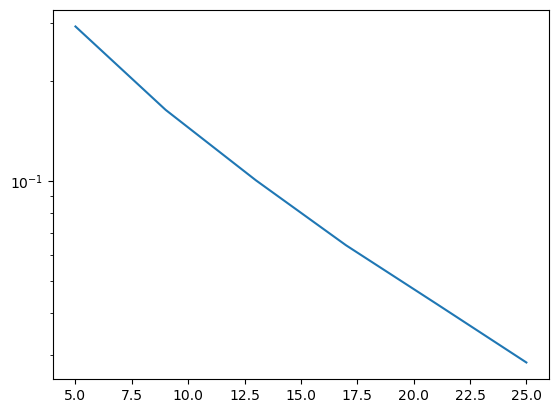

In [22]:
import matplotlib.pyplot as plt
plt.semilogy(K0_coll, np.mean(min_error_fou_test[6:,:], axis=0))
plt.show()

# Prova learning completo

In [47]:
h_prova = scipy.io.loadmat('h_prova.mat')
train_Y = h_prova["train_Y"]
train_X = h_prova["X_train"]

In [54]:
np.sum(train_Y)

79.27328679629646

In [171]:
D.shape

(100, 300)

In [172]:
X0.shape

(300, 150)

In [173]:
Y_train.shape

(100, 150, 10)

In [1]:
import dill
dill.load_session('new_prova_env.db')

In [2]:
import numpy as np
import cvxpy as cp

K0 = K0_coll[0]
sim = 7
c = c_true[sim]  # d
epsilon = epsilon_true[sim] 
D0, X0, discard = initialize_dic(Lu, Ld, s, k, Y_train[:, :, sim], k0, dictionary_type, c, epsilon, "only_X")
h_opt =0  ##############################################
X_opt_train=0
X_opt_test=0  ###########################################
# Define hyperparameters
min_error_train_norm, min_error_test_norm = 1e20, 1e20
m_test, m_train = Y_test.shape[1], Y_train.shape[1]
iter_, pat_iter = 1, 0

# Joint Dictionary
if dictionary_type == "joint":
    Lk, _, _ = compute_Lk_and_lambdak(Lu + Ld, k)
# Separated Dictionary
elif dictionary_type == "separated":
    Luk, _, _ = compute_Lk_and_lambdak(Lu, k, separated=True)
    Ldk, _, _ = compute_Lk_and_lambdak(Ld, k, separated=True)
# Edge Laplacian
elif dictionary_type == "edge_laplacian":
    Lk, _, _ = compute_Lk_and_lambdak(Ld, k)

# Init the dictionary and the sparse representation
D_coll = [cp.Constant(D0[:,(n*i):(n*(i+1))]) for i in range(s)]
X_train = X0
while pat_iter < patience and iter_ <= max_iter:
    
    # SDP Step
    I = cp.Constant(np.eye(n))

    if dictionary_type in ["joint", "edge_laplacian"]:
        h = cp.Variable((s, k))
        hI = cp.Variable((s, 1))
        for i in range(0,s):
            tmp =  cp.Constant(np.zeros((n, n)))
            for j in range(0,k):
                tmp += cp.multiply(h[i,j], Lk[j, :, :])
            tmp += cp.multiply(hI[i,:], I)
            D_coll[i] = tmp
        D = cp.hstack([D_coll[i]for i in range(s)])
        term1 = cp.norm(Y_train - D @ X_train, 'fro')**2
        term2 = lambda_ * cp.norm(h, 'fro')**2
        term3 = lambda_ * cp.norm(hI, 'fro')**2
        obj = cp.Minimize(term1+term2+term3)
    else:
        hI = cp.Variable((s, k))
        hS = cp.Variable((s, k))
        hH = cp.Variable((s, 1))
        for i in range(0,s):
            hu = hS[i,:]
            hd = hI[i,:]
            hid = hH[i]
            tmp =  cp.Constant(np.zeros((n, n)))
            for j in range(0,k):
                tmp += cp.multiply(hu[j], Luk[j, :, :]) + cp.multiply(hd[j], Ldk[j, :, :])
            tmp += cp.multiply(hid, I)
            D_coll[i] = tmp
        D = cp.hstack([D_coll[i]for i in range(s)])
        
        term1 = cp.norm(Y_train[:,:,7] - D @ X_train, 'fro')**2
        term2 = lambda_ * cp.norm(hI, 'fro')**2
        term3 = lambda_ * cp.norm(hS, 'fro')**2
        term4 = lambda_ * cp.norm(hH, 'fro')**2
        obj = cp.Minimize(term1 + term2 + term3 + term4)

    Dsum = cp.sum(D_coll)
    constraints = [D_coll[i] >= 0 * I for i in range(s)] + \
                    [D_coll[i] <= c * I for i in range(s)] + \
                    [Dsum >= cp.multiply((c - epsilon), I), Dsum <= cp.multiply((c + epsilon), I)]

    prob = cp.Problem(obj, constraints)
    prob.solve(solver=cp.CLARABEL, verbose=True)
    # Update the dictionary
    D = D.value

    # OMP Step
    dd = la.norm(D, axis=0)
    W = np.diag(1. / dd)
    Domp = D @ W
    X_train = np.apply_along_axis(lambda x: get_omp_coeff(K0, Domp=Domp, col=x), axis=0, arr=Y_train[:,:,7])
    X_test = np.apply_along_axis(lambda x: get_omp_coeff(K0, Domp=Domp, col=x), axis=0, arr=Y_test[:,:,7])
    # Normalize?
    X_train = W @ X_train
    X_test = W @ X_test

    # Error Updating
    error_train_norm = (1/m_train)* np.sum(la.norm(Y_train[:,:,7] - (D @ X_train), axis=0)**2 /
                            la.norm(Y_train[:,:,7], axis=0)**2)
    error_test_norm = (1/m_test)* np.sum(la.norm(Y_test[:,:,7] - (D @ X_test), axis=0)**2 /
                            la.norm(Y_test[:,:,7], axis=0)**2)

    # Error Storing
    if (error_train_norm < min_error_train_norm) and (abs(error_train_norm) > np.finfo(float).eps) and (abs(error_train_norm - min_error_train_norm) > tol):
        X_opt_train = X_train
        min_error_train_norm = error_train_norm

    if (error_test_norm < min_error_test_norm) and (abs(error_test_norm) > np.finfo(float).eps) and (abs(error_test_norm - min_error_test_norm) > tol):
        h_opt = h.value if dictionary_type in ["joint", "edge_laplacian"] else np.hstack([hI.value, hS.value, hH.value])
        D_opt = D
        X_opt_test = X_test
        min_error_test_norm = error_test_norm
        pat_iter = 0
        if verbose == 1:
            print("New Best Test Error:", min_error_test_norm)
    else:
        pat_iter += 1

    iter_ += 1


SyntaxError: invalid syntax (157716916.py, line 81)

In [187]:
D.shape

AttributeError: 'NoneType' object has no attribute 'shape'

In [176]:
D.shape

(100, 300)

In [167]:
D_coll[3].shape

IndexError: list index out of range

In [155]:
cp.installed_solvers()

['CLARABEL',
 'CVXOPT',
 'ECOS',
 'ECOS_BB',
 'GLPK',
 'GLPK_MI',
 'OSQP',
 'SCIPY',
 'SCS',
 'SDPA']

In [178]:
min_error_sep_train = np.zeros((n_sim, len(K0_coll)))
min_error_sep_test = np.zeros((n_sim, len(K0_coll)))

c = c_true[sim]  # d
epsilon = epsilon_true[sim] 
for k0_index, k0 in tqdm(enumerate(K0_coll)):
    # Initializations
    discard = 1
    while discard == 1:
        D0, X0, discard = initialize_dic(Lu, Ld, s, k, Y_train[:, :, sim], k0, dictionary_type, c, epsilon, "only_X")
    h_opt_sep, _, _, min_error_sep_train[sim, k0_index], min_error_sep_test[sim, k0_index] = topological_dictionary_learn(Y_train[:,:,sim], Y_test[:,:,sim], k, n, s, D0, X0, Lu, Ld, "separated", c, epsilon, k0, lambda_, max_iter, patience, tol)
    print(f"Simulation: {0+1}/{n_sim} Sparsity: {k0} Testing Separated... Done! Test Error: {min_error_sep_test[sim, k0_index]}")

0it [00:00, ?it/s]c:\Users\engri\Anaconda3\lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\engri\Anaconda3\lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\engri\Anaconda3\lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\engri\Anaconda3\lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
0it [00:20, ?it/s]


SolverError: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.

# Prova completa

In [125]:
import scipy.io
from tqdm import tqdm
mat = scipy.io.loadmat('datiSC.mat')
B1 = mat["B1"]
B2 = mat["B2"]

# Subsampling if needed to decrease complexity
sub_size = 100
B1 = B1[:, :sub_size]
B2 = B2[:sub_size, :]
B2 = B2[:,np.sum(np.abs(B2), 0) == 3]

# Laplacians
Ld = np.matmul(np.transpose(B1), B1, dtype=float)
Lu = np.matmul(B2, np.transpose(B2), dtype=float)
L = Lu+Ld
n =  L.shape[0]
nu = B2.shape[1]
nd = B1.shape[1]
_ ,U = la.eig(L)

# Problem and Dictionary Dimensionalities
dictionary_type_true = "separated"
m_train = 150 # Number of Train Signals
m_test = 80 # Number of Test Signal
s_true = 3 # Number of Kernels (Sub-dictionaries)
k_true = 2 # Polynomial order
sparsity = .1 # Sparsity percentage
K0_max = 20 #floor(n*sparsity) # Sparsity
sparsity_mode = "max"

# Data-Independent Problem Hyperparameters
dictionary_type = dictionary_type_true
s = s_true
k = k_true
K0_coll = np.arange(5, 26, 4) # K0_coll = 5:4:25 %4:4:40 %5:3:20
lambda_ = 1e-6 # l2 multiplier
max_iter = 100 # Maximum number of iterations
patience = 5 # Patience
tol = 1e-7 # Tolerance for Patience
n_sim = 10
verbose = 0


D_true = np.zeros((n, n * s_true, n_sim))
D_true_coll = np.zeros((n, n, s_true, n_sim))
Y_train = np.zeros((n, m_train, n_sim))
Y_test = np.zeros((n, m_test, n_sim))
epsilon_true = np.zeros(n_sim)
c_true = np.zeros(n_sim)
X_train = np.zeros((n * s, m_train, n_sim))
X_test = np.zeros((n * s, m_test, n_sim))
n_search = 3000

for sim in range(6, n_sim):
    # from there I can create a function to parallelize by the number of simulations
    best_sparsity = 0
    best_acc = 0

    for i in tqdm(range(n_search)):
        # try:
        D_try, h, Y_train_try, Y_test_try, epsilon_try, c_try, X_train_try, X_test_try = create_ground_truth(Lu,
                                                                                Ld,
                                                                                m_train,
                                                                                m_test, 
                                                                                s=s, 
                                                                                K=k, 
                                                                                K0=K0_max, 
                                                                                dictionary_type=dictionary_type, 
                                                                                sparsity_mode=sparsity_mode)
        # Replace with your actual function to verify dictionaries
        max_possible_sparsity, acc = verify_dic(D_try, Y_train_try, X_train_try, K0_max, .7)
        if max_possible_sparsity > best_sparsity:
            best_sparsity = max_possible_sparsity
            best_acc = acc
            D_true[:, :, sim] = D_try
            # D_true_coll[:, :, :, sim] = D_true_coll_tries
            Y_train[:, :, sim] = Y_train_try
            Y_test[:, :, sim] = Y_test_try
            epsilon_true[sim] = epsilon_try
            c_true[sim] = c_try
            X_train[:, :, sim] = X_train_try
            X_test[:, :, sim] = X_test_try

        # except Exception as e:
        #     print(f"Error during dictionary creation: {e}")

    print(f"...Done! # Best Sparsity: {best_sparsity}")

  0%|          | 0/3000 [00:00<?, ?it/s]

 17%|█▋        | 505/3000 [00:25<02:06, 19.77it/s]

In [23]:
import dill
dill.dump_session('prova_env.db')
# dill.load_session('prova_env.db')

In [4]:
np.sum(min_error_joint_train)

303.75241876828426

In [16]:
import matplotlib.pyplot as plt
# import warnings
# warnings.filterwarnings('ignore')
lambda_ = 1e-7 
# Initializations of Error Storing Variables
min_error_edge_train = np.zeros((n_sim, len(K0_coll)))
min_error_joint_train = np.zeros((n_sim, len(K0_coll)))
min_error_sep_train = np.zeros((n_sim, len(K0_coll)))
min_error_fou_train = np.zeros((n_sim, len(K0_coll)))
min_error_edge_test = np.zeros((n_sim, len(K0_coll)))
min_error_joint_test = np.zeros((n_sim, len(K0_coll)))
min_error_sep_test = np.zeros((n_sim, len(K0_coll)))
min_error_fou_test = np.zeros((n_sim, len(K0_coll)))


verbose = 0
for sim in range(6,n_sim):
    c = c_true[sim]  # d
    epsilon = epsilon_true[sim]  # epsilon
    for k0_index, k0 in tqdm(enumerate(K0_coll)):
        # Initializations
        discard = 1
        while discard == 1:
            D0, X0, discard = initialize_dic(Lu, Ld, s, k, Y_train[:, :, sim], k0, dictionary_type, c, epsilon, "only_X")
        try:
            h_opt_edge, _, _, min_error_edge_train[sim, k0_index], min_error_edge_test[sim, k0_index] = topological_dictionary_learn(Y_train[:,:,sim], Y_test[:,:,sim], k, n, s, D0, X0, Lu, Ld, "edge_laplacian", c, epsilon, k0, lambda_, max_iter, patience, tol)
            print(f"Simulation: {sim+1}/{n_sim} Sparsity: {k0} Testing Edge Laplacian... Done! Test Error: {min_error_edge_test[sim, k0_index]}")
        except Exception as e:
            min_error_edge_train[sim, k0_index] = 100
            min_error_edge_test[sim, k0_index] = 100
            print(f"Divergent Run in Edge Laplacian... Discarded! Error: {e}")
        try:
            h_opt_joint, _, _, min_error_joint_train[sim, k0_index], min_error_joint_test[sim, k0_index] = topological_dictionary_learn(Y_train[:,:,sim], Y_test[:,:,sim], k, n, s, D0, X0, Lu, Ld, "joint", c, epsilon, k0, lambda_, max_iter, patience, tol)
            print(f"Simulation: {sim+1}/{n_sim} Sparsity: {k0} Testing Joint... Done! Test Error: {min_error_joint_test[sim, k0_index]}")
        except Exception as e:
            min_error_joint_train[sim, k0_index] = 100
            min_error_joint_test[sim, k0_index] = 100
            print(f"Divergent Run in joint... Discarded! Error: {e}")
        try:
            h_opt_sep, _, _, min_error_sep_train[sim, k0_index], min_error_sep_test[sim, k0_index] = topological_dictionary_learn(Y_train[:,:,sim], Y_test[:,:,sim], k, n, s, D0, X0, Lu, Ld, "separated", c, epsilon, k0, lambda_, max_iter, patience, tol)
            print(f"Simulation: {sim+1}/{n_sim} Sparsity: {k0} Testing Separated... Done! Test Error: {min_error_sep_test[sim, k0_index]}")
        except Exception as e:
            min_error_sep_train[sim, k0_index] = 100
            min_error_sep_test[sim, k0_index] = 100
            print(f"Divergent Run in Separated... Discarded! Error: {e}")


0it [00:00, ?it/s]C:\Users\engri\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_omp.py:420: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  out = _cholesky_omp(
c:\Users\engri\Anaconda3\lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\engri\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_omp.py:420: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  out = _cholesky_omp(
C:\Users\engri\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_omp.py:420: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. Th

Simulation: 7/10 Sparsity: 5 Testing Edge Laplacian... Done! Test Error: 0.35160859903636266


C:\Users\engri\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_omp.py:420: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  out = _cholesky_omp(
c:\Users\engri\Anaconda3\lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\engri\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_omp.py:420: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  out = _cholesky_omp(
C:\Users\engri\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_omp.py:420: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precis

Simulation: 7/10 Sparsity: 5 Testing Joint... Done! Test Error: 0.35160859893667157


C:\Users\engri\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_omp.py:420: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  out = _cholesky_omp(
1it [00:14, 14.39s/it]

Simulation: 7/10 Sparsity: 5 Testing Separated... Done! Test Error: 0.351608590911353


C:\Users\engri\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_omp.py:420: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  out = _cholesky_omp(
C:\Users\engri\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_omp.py:420: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  out = _cholesky_omp(
c:\Users\engri\Anaconda3\lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\engri\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_omp.py:420: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precis

Simulation: 7/10 Sparsity: 9 Testing Edge Laplacian... Done! Test Error: 0.23996023681339235


C:\Users\engri\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_omp.py:420: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  out = _cholesky_omp(
C:\Users\engri\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_omp.py:420: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  out = _cholesky_omp(
c:\Users\engri\Anaconda3\lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\engri\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_omp.py:420: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precis

Simulation: 7/10 Sparsity: 9 Testing Joint... Done! Test Error: 0.2399602363805004


C:\Users\engri\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_omp.py:420: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  out = _cholesky_omp(
C:\Users\engri\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_omp.py:420: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  out = _cholesky_omp(
C:\Users\engri\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_omp.py:420: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  out = _cholesky_omp(
C:\Users\engri\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_omp.py:420: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence

Simulation: 7/10 Sparsity: 9 Testing Separated... Done! Test Error: 0.23996023593709842


C:\Users\engri\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_omp.py:420: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  out = _cholesky_omp(
c:\Users\engri\Anaconda3\lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\engri\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_omp.py:420: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  out = _cholesky_omp(
C:\Users\engri\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_omp.py:420: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precis

Simulation: 7/10 Sparsity: 13 Testing Edge Laplacian... Done! Test Error: 0.17046211503351724


C:\Users\engri\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_omp.py:420: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  out = _cholesky_omp(
c:\Users\engri\Anaconda3\lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\engri\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_omp.py:420: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  out = _cholesky_omp(
c:\Users\engri\Anaconda3\lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  war

Simulation: 7/10 Sparsity: 13 Testing Joint... Done! Test Error: 0.17046211458478208


C:\Users\engri\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_omp.py:420: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  out = _cholesky_omp(
C:\Users\engri\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_omp.py:420: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  out = _cholesky_omp(
C:\Users\engri\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_omp.py:420: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  out = _cholesky_omp(
C:\Users\engri\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_omp.py:420: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence

Simulation: 7/10 Sparsity: 13 Testing Separated... Done! Test Error: 0.17046211412057097


C:\Users\engri\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_omp.py:420: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  out = _cholesky_omp(
C:\Users\engri\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_omp.py:420: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  out = _cholesky_omp(
c:\Users\engri\Anaconda3\lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\engri\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_omp.py:420: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precis

Simulation: 7/10 Sparsity: 17 Testing Edge Laplacian... Done! Test Error: 0.1232067880060797


C:\Users\engri\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_omp.py:420: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  out = _cholesky_omp(
c:\Users\engri\Anaconda3\lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\engri\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_omp.py:420: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  out = _cholesky_omp(
C:\Users\engri\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_omp.py:420: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precis

Simulation: 7/10 Sparsity: 17 Testing Joint... Done! Test Error: 0.1232067871077492


C:\Users\engri\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_omp.py:420: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  out = _cholesky_omp(
C:\Users\engri\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_omp.py:420: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  out = _cholesky_omp(
C:\Users\engri\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_omp.py:420: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  out = _cholesky_omp(
C:\Users\engri\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_omp.py:420: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence

Simulation: 7/10 Sparsity: 17 Testing Separated... Done! Test Error: 0.12320678505374648


C:\Users\engri\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_omp.py:420: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  out = _cholesky_omp(
C:\Users\engri\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_omp.py:420: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  out = _cholesky_omp(
c:\Users\engri\Anaconda3\lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\engri\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_omp.py:420: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precis

Simulation: 7/10 Sparsity: 21 Testing Edge Laplacian... Done! Test Error: 0.09003750888311528


c:\Users\engri\Anaconda3\lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\engri\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_omp.py:420: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  out = _cholesky_omp(
C:\Users\engri\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_omp.py:420: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  out = _cholesky_omp(
c:\Users\engri\Anaconda3\lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  war

Simulation: 7/10 Sparsity: 21 Testing Joint... Done! Test Error: 0.09003750864481869


C:\Users\engri\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_omp.py:420: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  out = _cholesky_omp(
C:\Users\engri\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_omp.py:420: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  out = _cholesky_omp(
C:\Users\engri\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_omp.py:420: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  out = _cholesky_omp(
C:\Users\engri\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_omp.py:420: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence

Simulation: 7/10 Sparsity: 21 Testing Separated... Done! Test Error: 0.09003750830280875


C:\Users\engri\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_omp.py:420: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  out = _cholesky_omp(
c:\Users\engri\Anaconda3\lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\engri\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_omp.py:420: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  out = _cholesky_omp(
c:\Users\engri\Anaconda3\lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  war

Simulation: 7/10 Sparsity: 25 Testing Edge Laplacian... Done! Test Error: 0.06594837174684479


C:\Users\engri\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_omp.py:420: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  out = _cholesky_omp(
C:\Users\engri\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_omp.py:420: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  out = _cholesky_omp(
c:\Users\engri\Anaconda3\lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\engri\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_omp.py:420: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precis

Simulation: 7/10 Sparsity: 25 Testing Joint... Done! Test Error: 0.06594837074782203


C:\Users\engri\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_omp.py:420: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  out = _cholesky_omp(
c:\Users\engri\Anaconda3\lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\engri\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_omp.py:420: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  out = _cholesky_omp(
c:\Users\engri\Anaconda3\lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  war

Simulation: 7/10 Sparsity: 25 Testing Separated... Done! Test Error: 0.06594836910567094


0it [00:00, ?it/s]c:\Users\engri\Anaconda3\lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\engri\Anaconda3\lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\engri\Anaconda3\lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\engri\Anaconda3\lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\engri\Anaconda3\lib\site-packages\cvxpy\p

Simulation: 8/10 Sparsity: 5 Testing Edge Laplacian... Done! Test Error: 0.39143664153878505


c:\Users\engri\Anaconda3\lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\engri\Anaconda3\lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\engri\Anaconda3\lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\engri\Anaconda3\lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\engri\Anaconda3\lib\site-packages\cvxpy\problems\problem.py

Divergent Run in joint... Discarded! Error: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.


c:\Users\engri\Anaconda3\lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\engri\Anaconda3\lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\engri\Anaconda3\lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\engri\Anaconda3\lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\engri\Anaconda3\lib\site-packages\cvxpy\problems\problem.py

Simulation: 8/10 Sparsity: 5 Testing Separated... Done! Test Error: 0.38448316043847297


C:\Users\engri\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_omp.py:420: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  out = _cholesky_omp(
c:\Users\engri\Anaconda3\lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\engri\Anaconda3\lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Divergent Run in Edge Laplacian... Discarded! Error: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Divergent Run in joint... Discarded! Error: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.


c:\Users\engri\Anaconda3\lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\engri\Anaconda3\lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\engri\Anaconda3\lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
2it [00:43, 20.63s/it]

Divergent Run in Separated... Discarded! Error: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.


C:\Users\engri\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_omp.py:420: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  out = _cholesky_omp(
C:\Users\engri\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_omp.py:420: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  out = _cholesky_omp(
c:\Users\engri\Anaconda3\lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\engri\Anaconda3\lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  war

Simulation: 8/10 Sparsity: 13 Testing Edge Laplacian... Done! Test Error: 0.19600768016011608


C:\Users\engri\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_omp.py:420: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  out = _cholesky_omp(
c:\Users\engri\Anaconda3\lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\engri\Anaconda3\lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\engri\Anaconda3\lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\engri\Anaconda3\lib

Simulation: 8/10 Sparsity: 13 Testing Joint... Done! Test Error: 0.19512052158021037


C:\Users\engri\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_omp.py:420: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  out = _cholesky_omp(
c:\Users\engri\Anaconda3\lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
3it [01:09, 23.33s/it]

Divergent Run in Separated... Discarded! Error: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.


C:\Users\engri\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_omp.py:420: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  out = _cholesky_omp(
C:\Users\engri\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_omp.py:420: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  out = _cholesky_omp(
c:\Users\engri\Anaconda3\lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\engri\Anaconda3\lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  war

Divergent Run in Edge Laplacian... Discarded! Error: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.


C:\Users\engri\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_omp.py:420: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  out = _cholesky_omp(
c:\Users\engri\Anaconda3\lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\engri\Anaconda3\lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Divergent Run in joint... Discarded! Error: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.


C:\Users\engri\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_omp.py:420: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  out = _cholesky_omp(
c:\Users\engri\Anaconda3\lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
4it [01:27, 21.02s/it]

Divergent Run in Separated... Discarded! Error: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.


C:\Users\engri\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_omp.py:420: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  out = _cholesky_omp(
C:\Users\engri\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_omp.py:420: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  out = _cholesky_omp(
c:\Users\engri\Anaconda3\lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\engri\Anaconda3\lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  war

Simulation: 8/10 Sparsity: 21 Testing Edge Laplacian... Done! Test Error: 0.10667288635542894


C:\Users\engri\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_omp.py:420: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  out = _cholesky_omp(
C:\Users\engri\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_omp.py:420: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  out = _cholesky_omp(
C:\Users\engri\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_omp.py:420: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  out = _cholesky_omp(
C:\Users\engri\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_omp.py:420: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence

Simulation: 8/10 Sparsity: 21 Testing Joint... Done! Test Error: 0.10667288687096024


c:\Users\engri\Anaconda3\lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\engri\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_omp.py:420: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  out = _cholesky_omp(
5it [01:52, 22.45s/it]

Simulation: 8/10 Sparsity: 21 Testing Separated... Done! Test Error: 0.10667288676700976


C:\Users\engri\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_omp.py:420: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  out = _cholesky_omp(
C:\Users\engri\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_omp.py:420: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  out = _cholesky_omp(
C:\Users\engri\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_omp.py:420: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  out = _cholesky_omp(
c:\Users\engri\Anaconda3\lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with 

Simulation: 8/10 Sparsity: 25 Testing Edge Laplacian... Done! Test Error: 0.07799215757718087


C:\Users\engri\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_omp.py:420: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  out = _cholesky_omp(
C:\Users\engri\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_omp.py:420: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  out = _cholesky_omp(
C:\Users\engri\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_omp.py:420: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  out = _cholesky_omp(
C:\Users\engri\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_omp.py:420: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence

Simulation: 8/10 Sparsity: 25 Testing Joint... Done! Test Error: 0.07799215916525086


C:\Users\engri\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_omp.py:420: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  out = _cholesky_omp(
C:\Users\engri\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_omp.py:420: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  out = _cholesky_omp(
C:\Users\engri\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_omp.py:420: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  out = _cholesky_omp(
C:\Users\engri\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_omp.py:420: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence

Simulation: 8/10 Sparsity: 25 Testing Separated... Done! Test Error: 0.07799215860093955


0it [00:00, ?it/s]c:\Users\engri\Anaconda3\lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Simulation: 9/10 Sparsity: 5 Testing Edge Laplacian... Done! Test Error: 0.43174788221231875


c:\Users\engri\Anaconda3\lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\engri\Anaconda3\lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Simulation: 9/10 Sparsity: 5 Testing Joint... Done! Test Error: 0.43174790058813994


1it [00:14, 14.89s/it]

Simulation: 9/10 Sparsity: 5 Testing Separated... Done! Test Error: 0.4317478855653525


c:\Users\engri\Anaconda3\lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Simulation: 9/10 Sparsity: 9 Testing Edge Laplacian... Done! Test Error: 0.30497342117202875
Simulation: 9/10 Sparsity: 9 Testing Joint... Done! Test Error: 0.30497342410066763


2it [00:32, 16.38s/it]

Simulation: 9/10 Sparsity: 9 Testing Separated... Done! Test Error: 0.30497341887814655


c:\Users\engri\Anaconda3\lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Simulation: 9/10 Sparsity: 13 Testing Edge Laplacian... Done! Test Error: 0.22196592293625117


c:\Users\engri\Anaconda3\lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\engri\Anaconda3\lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Simulation: 9/10 Sparsity: 13 Testing Joint... Done! Test Error: 0.2219659241229232


c:\Users\engri\Anaconda3\lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\engri\Anaconda3\lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
3it [00:51, 17.78s/it]

Simulation: 9/10 Sparsity: 13 Testing Separated... Done! Test Error: 0.2219659301559893


c:\Users\engri\Anaconda3\lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\engri\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_omp.py:420: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  out = _cholesky_omp(


Simulation: 9/10 Sparsity: 17 Testing Edge Laplacian... Done! Test Error: 0.1652286172422862


c:\Users\engri\Anaconda3\lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\engri\Anaconda3\lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Simulation: 9/10 Sparsity: 17 Testing Joint... Done! Test Error: 0.16522863551245573


c:\Users\engri\Anaconda3\lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\engri\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_omp.py:420: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  out = _cholesky_omp(
c:\Users\engri\Anaconda3\lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
4it [01:14, 19.67s/it]

Simulation: 9/10 Sparsity: 17 Testing Separated... Done! Test Error: 0.16522861190080496


c:\Users\engri\Anaconda3\lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Simulation: 9/10 Sparsity: 21 Testing Edge Laplacian... Done! Test Error: 0.12347227265081467


c:\Users\engri\Anaconda3\lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\engri\Anaconda3\lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Simulation: 9/10 Sparsity: 21 Testing Joint... Done! Test Error: 0.1234722696368533


c:\Users\engri\Anaconda3\lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\engri\Anaconda3\lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\engri\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_omp.py:420: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  out = _cholesky_omp(
C:\Users\engri\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_omp.py:420: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  out = _ch

Simulation: 9/10 Sparsity: 21 Testing Separated... Done! Test Error: 0.12347226909903657


c:\Users\engri\Anaconda3\lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\engri\Anaconda3\lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\engri\Anaconda3\lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Simulation: 9/10 Sparsity: 25 Testing Edge Laplacian... Done! Test Error: 0.09200483042289566


c:\Users\engri\Anaconda3\lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Simulation: 9/10 Sparsity: 25 Testing Joint... Done! Test Error: 0.09200482551558867


6it [02:07, 21.22s/it]


Simulation: 9/10 Sparsity: 25 Testing Separated... Done! Test Error: 0.09200482205059692


0it [00:00, ?it/s]c:\Users\engri\Anaconda3\lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\engri\Anaconda3\lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
c:\Users\engri\Anaconda3\lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Simulation: 10/10 Sparsity: 5 Testing Edge Laplacian... Done! Test Error: 0.41267032980334784


c:\Users\engri\Anaconda3\lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(


Simulation: 10/10 Sparsity: 5 Testing Joint... Done! Test Error: 0.412670330325369


1it [00:10, 10.48s/it]

Divergent Run in Separated... Discarded! Error: Solver 'CLARABEL' failed. Try another solver, or solve with verbose=True for more information.
Simulation: 10/10 Sparsity: 9 Testing Edge Laplacian... Done! Test Error: 0.2709458995043373
Simulation: 10/10 Sparsity: 9 Testing Joint... Done! Test Error: 0.2709458995025697


2it [00:26, 13.88s/it]

Simulation: 10/10 Sparsity: 9 Testing Separated... Done! Test Error: 0.27094589937708824
Simulation: 10/10 Sparsity: 13 Testing Edge Laplacian... Done! Test Error: 0.18325538655884924
Simulation: 10/10 Sparsity: 13 Testing Joint... Done! Test Error: 0.18325538671826072


3it [00:45, 16.21s/it]

Simulation: 10/10 Sparsity: 13 Testing Separated... Done! Test Error: 0.1832553869731139
Simulation: 10/10 Sparsity: 17 Testing Edge Laplacian... Done! Test Error: 0.12997464449908744


C:\Users\engri\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_omp.py:420: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  out = _cholesky_omp(
C:\Users\engri\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_omp.py:420: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  out = _cholesky_omp(


Simulation: 10/10 Sparsity: 17 Testing Joint... Done! Test Error: 0.12997464447839593


4it [01:08, 18.64s/it]

Simulation: 10/10 Sparsity: 17 Testing Separated... Done! Test Error: 0.12997464471835285


c:\Users\engri\Anaconda3\lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\engri\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_omp.py:420: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  out = _cholesky_omp(
c:\Users\engri\Anaconda3\lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\engri\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_omp.py:420: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  out = _ch

Simulation: 10/10 Sparsity: 21 Testing Edge Laplacian... Done! Test Error: 0.09266794952062422


C:\Users\engri\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_omp.py:420: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  out = _cholesky_omp(
C:\Users\engri\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_omp.py:420: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  out = _cholesky_omp(
C:\Users\engri\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_omp.py:420: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  out = _cholesky_omp(


Simulation: 10/10 Sparsity: 21 Testing Joint... Done! Test Error: 0.09266794989706746


c:\Users\engri\Anaconda3\lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\engri\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_omp.py:420: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  out = _cholesky_omp(
C:\Users\engri\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_omp.py:420: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  out = _cholesky_omp(
C:\Users\engri\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_omp.py:420: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precis

Simulation: 10/10 Sparsity: 21 Testing Separated... Done! Test Error: 0.09266794954592586


C:\Users\engri\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_omp.py:420: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  out = _cholesky_omp(
c:\Users\engri\Anaconda3\lib\site-packages\cvxpy\problems\problem.py:1403: UserWarning: Solution may be inaccurate. Try another solver, adjusting the solver settings, or solve with verbose=True for more information.
  warnings.warn(
C:\Users\engri\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_omp.py:420: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  out = _cholesky_omp(
C:\Users\engri\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_omp.py:420: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precis

Simulation: 10/10 Sparsity: 25 Testing Edge Laplacian... Done! Test Error: 0.06691331566683856


C:\Users\engri\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_omp.py:420: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  out = _cholesky_omp(
C:\Users\engri\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_omp.py:420: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  out = _cholesky_omp(
C:\Users\engri\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_omp.py:420: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  out = _cholesky_omp(
C:\Users\engri\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_omp.py:420: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence

Simulation: 10/10 Sparsity: 25 Testing Joint... Done! Test Error: 0.066913315894725


C:\Users\engri\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_omp.py:420: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  out = _cholesky_omp(
C:\Users\engri\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_omp.py:420: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  out = _cholesky_omp(
C:\Users\engri\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_omp.py:420: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence in the dictionary. The requested precision might not have been met.
  out = _cholesky_omp(
C:\Users\engri\AppData\Roaming\Python\Python39\site-packages\sklearn\linear_model\_omp.py:420: RuntimeWarning: Orthogonal matching pursuit ended prematurely due to linear dependence

Simulation: 10/10 Sparsity: 25 Testing Separated... Done! Test Error: 0.06691331559791452


In [10]:
print(cp.installed_solvers())

['CLARABEL', 'CVXOPT', 'ECOS', 'ECOS_BB', 'GLPK', 'GLPK_MI', 'OSQP', 'SCIPY', 'SCS', 'SDPA']


# Curve plotting

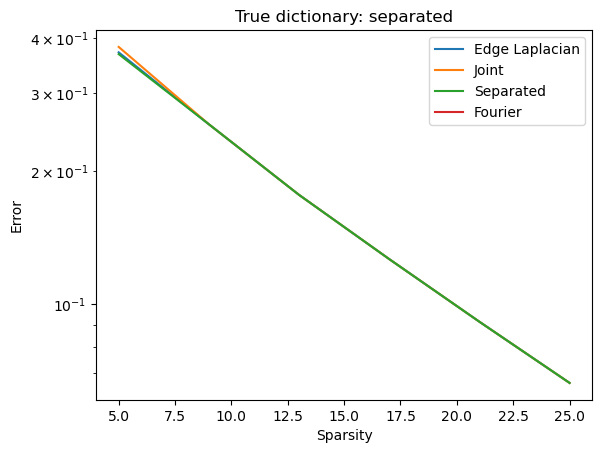

In [20]:
import numpy as np
import matplotlib.pyplot as plt

def process_data(min_error_test, n_keep):
    n_k = min_error_test.shape[1]
    selected_errors = np.zeros((n_keep, n_k))

    for el in range(n_k):
        # Get indices of the smallest n_keep elements
        idx = np.argpartition(min_error_test[:, el], n_keep)[:n_keep]
        # Use these indices to preserve the original order in the selected subset
        selected_errors[:, el] = min_error_test[idx, el]

    return selected_errors

# Example of processing the data
n_sim = min_error_edge_test.shape[0]
n_keep = n_sim - 2


min_error_edge_test_separated = process_data(min_error_edge_test, n_keep)
min_error_joint_test_separated = process_data(min_error_joint_test, n_keep)
min_error_sep_test_separated = process_data(min_error_sep_test, n_keep)
min_error_fou_test_separated = process_data(min_error_fou_test, n_keep)

# Sparsity levels
K0_coll = np.arange(5, 26, 4)

# Plotting function
def plot_errors(min_errors, labels, title):
    plt.figure()
    for min_error, label in zip(min_errors, labels):
        plt.semilogy(K0_coll, np.mean(min_error, axis=0), label=label)
    plt.xlabel('Sparsity')
    plt.ylabel('Error')
    plt.title(title)
    plt.legend()
    plt.show()

plot_errors(
    [min_error_edge_test_separated[6:,:], min_error_joint_test_separated[6:,:], min_error_sep_test_separated[6:,:], min_error_fou_test_separated[6:,:]],
    ["Edge Laplacian", "Joint", "Separated", "Fourier"],
    f"True dictionary: {dictionary_type_true}"
)

# Vettorizzazione for esterni

In [935]:
import scipy.io
mat = scipy.io.loadmat('datiSC.mat')
B1 = mat["B1"]
B2 = mat["B2"]

# Subsampling if needed to decrease complexity
sub_size = 100
B1 = B1[:, :sub_size]
B2 = B2[:sub_size, :]
B2 = B2[:,np.sum(np.abs(B2), 0) == 3]

# Laplacians
Ld = np.matmul(np.transpose(B1), B1, dtype=float)
Lu = np.matmul(B2, np.transpose(B2), dtype=float)
L = Lu+Ld
n =  L.shape[0]
nu = B2.shape[1]
nd = B1.shape[1]
_ ,U = la.eig(L)

# Problem and Dictionary Dimensionalities
dictionary_type_true = "separated"
m_train = 150 # Number of Train Signals
m_test = 80 # Number of Test Signal
s_true = 3 # Number of Kernels (Sub-dictionaries)
k_true = 2 # Polynomial order
sparsity = .1 # Sparsity percentage
K0_max = 20 #floor(n*sparsity) # Sparsity
sparsity_mode = "max"

# Data-Independent Problem Hyperparameters
dictionary_type = dictionary_type_true
s = s_true
k = k_true
K0_coll = np.arange(5, 26, 4) # K0_coll = 5:4:25 %4:4:40 %5:3:20
lambda_ = 1e-6 # l2 multiplier
max_iter = 100 # Maximum number of iterations
patience = 5 # Patience
tol = 1e-7 # Tolerance for Patience
n_sim = 10
verbose = 0
# for sim in range(5,n_sim):
tmp_res = pd.DataFrame()
def vectorized_generation(Lu,Ld,m_train,m_test,s, K, K0, dictionary_type, sparsity_mode):
    D_try, h, Y_train_try, Y_test_try, epsilon_try, c_try, X_train_try, X_test_try = create_ground_truth(Lu,
                                                                                Ld,
                                                                                m_train,
                                                                                m_test, 
                                                                                s=s, 
                                                                                K=K, 
                                                                                K0=K0, 
                                                                                dictionary_type=dictionary_type, 
                                                                                sparsity_mode=sparsity_mode)
    res_dict ={"D_try":D_try,
            "h":h,
            "Y_train_try":Y_train_try,
            "Y_test_try":Y_test_try,
            "epsilon_try":epsilon_try,
            "c_try":c_try,
            "X_train_try":X_train_try,
            "X_test_try":X_test_try}
    return res_dict

def vectorized_verify(row, K0_max, acc_tresh):
    D_try=row["D_try"]
    Y_train_try=row["Y_train_try"]
    X_train_try=row["X_train_try"]
    max_possible_sparsity, acc = verify_dic(D_try, Y_train_try, X_train_try, K0_max, acc_tresh)
    row["acc"] = acc
    row["max_s"] = max_possible_sparsity
    return row

tmp_res["search"] = np.arange(3000)
tmp_res["res_dict"] = tmp_res.search.apply(lambda row: vectorized_generation(Lu,Ld,m_train,m_test,s=s, K=k, K0=K0_max, dictionary_type=dictionary_type, sparsity_mode=sparsity_mode))
tmp_res["res_dict"] = tmp_res.res_dict.apply(lambda row:  vectorized_verify(row, K0_max, 0.7))